# A class for a tesseroid relief 

There is a `PrismRelief` mesh class in [Fatiando a Terra](http://www.fatiando.org/) but we still need a `TesseroidRelief` for this inversion. This is a mesh of tesseroids distributed along an area. They ondulate below and above a reference level, describing the relief of an interface. Tesseroids have either the top of bottom fixed to a reference height. The other end ondulates along a relief.

The `TesseroidRelief` class is defined in the [`tesseroid_mesh.py`](tesseroid_mesh.py) file.

## Example usage

In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import multiprocessing
from fatiando import gridder, utils
from fatiando.vis import myv
from fatiando.gravmag import tesseroid
import fatiando
from tesseroid_mesh import TesseroidRelief

In [2]:
print(fatiando.__version__)

d3a8f4acd29a5377ccbd45c717863b909a8a0a1c


### Create the mesh using a synthetic relief

In [3]:
# shape is nlat, nlon = the number of points in the grid
shape = (41, 31)
# Make a regular grid inside an area = (s, n, w, e)
area = (20, 60, -40, 40)
lat, lon, h = gridder.regular(area, shape, z=250e3)
# The model area is slightly larger because the points generated above areae in the center of each cell.
dlat, dlon = gridder.spacing(area, shape)
s, n, w, e = area
modelarea = (s - dlat/2, n + dlat/2, w - dlon/2, e + dlon/2)
# Make a checkerboard relief undulating along the -35km height reference
f = 0.2
reference = -35e3
relief = 10e3*np.sin(0.5*f*lon)*np.cos(f*lat) + reference
# The density contrast is negative if the relief is below the reference
density = 600*np.ones_like(relief)
density[relief < reference] *= -1

In [4]:
sample_mesh = TesseroidRelief(modelarea, shape, relief, reference, {'density': density})

In [5]:
def plot_result_3d(moho, fname):
    bounds = modelarea + (-20e3, -60e3)
    scale = (1, 1, 40) # Exaggerate the radial dimension
    datarange = np.abs([moho.props['density'].max(), moho.props['density'].min()]).max()
    scene = myv.figure(zdown=False)
    plot = myv.tesseroids(moho, 'density', scale=scale)
    plot.module_manager.scalar_lut_manager.show_legend = True
    plot.module_manager.scalar_lut_manager.lut_mode = 'RdYlBu'
    plot.module_manager.scalar_lut_manager.data_range = [-datarange, datarange]
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.minimum_size = np.array([1, 1])
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.position2 = np.array([ 0.13741855,  0.64385382])
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.position = np.array([ 0.03303258,  0.07342193])
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.maximum_size = np.array([100000, 100000])
    plot.module_manager.scalar_lut_manager.label_text_property.color = (0, 0, 0)
    plot.module_manager.scalar_lut_manager.title_text_property.color = (0, 0, 0)
    scene.scene.camera.position = [2252864.9143914036, -5202911.2574882135, 8495162.9722945951]
    scene.scene.camera.focal_point = [3135763.9476126051, 1056258.4985192744, 829277.18542720564]
    scene.scene.camera.view_angle = 30.0
    scene.scene.camera.view_up = [0.6164057832087273, 0.57367112225287575, 0.53939350563383837]
    scene.scene.camera.clipping_range = [783483.44437851617, 16078402.004277557]
    scene.scene.camera.compute_view_plane_normal()
    scene.scene.render()
    myv.savefig(fname)
    #myv.show()
    myv.mlab.close()
    return Image(filename=fname)    

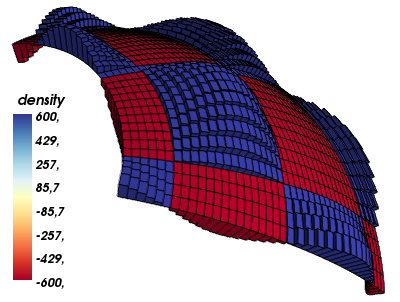

In [6]:
plot_result_3d(sample_mesh, 'example-mesh.png')

### Calculate the gravity effect of this mesh

In [7]:
ncpu = multiprocessing.cpu_count()
ncpu

4

In [8]:
gz = tesseroid.gz(lon, lat, h, sample_mesh, njobs=ncpu)
gz = utils.contaminate(gz, 0.5)

In [9]:
np.linspace(0, 5, 5, endpoint=False)

array([ 0.,  1.,  2.,  3.,  4.])

/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/matplotlib/tri/triangulation.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  self._neighbors)


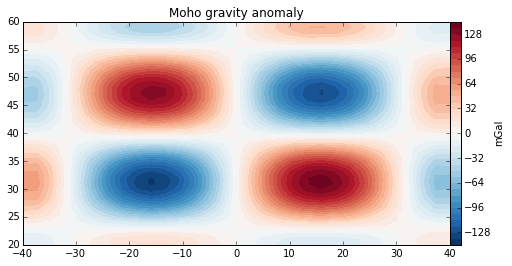

In [10]:
plt.figure(figsize=(9, 4))
plt.title('Moho gravity anomaly')
plt.tricontourf(lon, lat, gz, 40, cmap='RdBu_r')
plt.colorbar(pad=0).set_label('mGal')